## Basic classifier that uses Bidirectional Gated Recurrent Unit (bigru) to predict if the payload is an SQL injection

Let's import our stuff here


In [2]:
!pip3 install scikit-learn>=1.0.0
!pip3 install ktrain matplotlib tensorflow numpy
import matplotlib
import os
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Some more imports...We are using ktrain wrapper to simplify model operations and take advantage of some cool stuff like autofit

In [3]:
import ktrain
from ktrain import text

Here, we will classify payload to "malicious sqli" and "benign" . Data set is presented as a CSV file (i.e., download the file ```SQLiV3a_.csv```).  We will load the data using the ```texts_from_csv``` method, which assumes the label_columns are already one-hot-encoded in the spreadsheet. Since *val_filepath* is None, 10% of the data will automatically be used as a validation set.


In [4]:
DATA_PATH = 'SQLiV3a_14k.csv'
NUM_WORDS = 50000
MAXLEN = 200
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH,
                      'payload',
                      label_columns = ["type"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1,
                      preprocess_mode='bert')

detected encoding: UTF-8-SIG (if wrong, set manually)
['benign', 'sqli', 'xss']
       benign  sqli  xss
4662      1.0   0.0  0.0
3215      0.0   1.0  0.0
5230      1.0   0.0  0.0
9135      1.0   0.0  0.0
11136     0.0   0.0  1.0
['benign', 'sqli', 'xss']
       benign  sqli  xss
8213      0.0   0.0  1.0
8312      0.0   0.0  1.0
5578      0.0   1.0  0.0
5659      0.0   0.0  1.0
12384     1.0   0.0  0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Load the learner instance that uses ```bigru``` model 

In [5]:
model = text.text_classifier('bert', (x_train, y_train), 
                             preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

Is Multi-Label? False
maxlen is 100
done.


Now let's find the optimal learning rate for this model

In [4]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


simulating training for different learning rates... this may take a few moments...
Epoch 1/2
406/406 [==============================] - 1989s 5s/step - loss: 0.4561 - accuracy: 0.7909
Epoch 2/2
406/406 [==============================] - 772s 2s/step - loss: 2.6124 - accuracy: 0.3395


done.
Visually inspect loss plot and select learning rate associated with falling loss


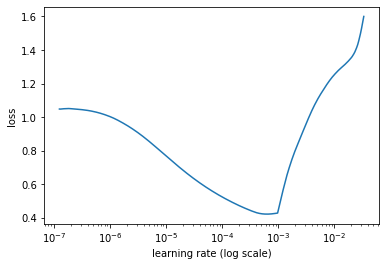

In [6]:
learner.lr_find(show_plot=True, max_epochs=2)

Train the model using the optimal learning rate ( adjust argument as needed accorfing to the graph)

In [8]:
learner.freeze(104)

In [9]:
learner.autofit(0.001)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
406/406 [==============================] - 729s 2s/step - loss: 0.0644 - accuracy: 0.9797 - val_loss: 0.0140 - val_accuracy: 0.9945
Epoch 2/1024
406/406 [==============================] - 711s 2s/step - loss: 0.0220 - accuracy: 0.9926 - val_loss: 0.0107 - val_accuracy: 0.9965
Epoch 3/1024
406/406 [==============================] - 711s 2s/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0160 - val_accuracy: 0.9945
Epoch 4/1024
406/406 [==============================] - 713s 2s/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0082 - val_accuracy: 0.9965
Epoch 5/1024
406/406 [==============================] - 714s 2s/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0162 - val_accuracy: 0.9965
Epoch 6/1024
406/406 [==============================] - 714s 2s/step - loss: 0.0152 - accur

Now let's evaluate the the ```validation data set```

In [ ]:
learner.evaluate()

Here is what our model looks like. It has a number of layers that comprise this ```GRU```

In [7]:
learner.print_layers()


0 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7fc7d404b790>
1 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7fc7d404bdc0>
2 (trainable=True) : <keras_bert.layers.embedding.TokenEmbedding object at 0x7fc7d404bd90>
3 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7fc7d404bf40>
4 (trainable=True) : <keras.layers.merge.Add object at 0x7fc7d40317c0>
5 (trainable=True) : <keras_pos_embd.pos_embd.PositionEmbedding object at 0x7fc7d404e580>
6 (trainable=True) : <keras.layers.core.dropout.Dropout object at 0x7fc7d404e250>
7 (trainable=True) : <keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7fc7d404e3d0>
8 (trainable=True) : <keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7fc824412c40>
9 (trainable=True) : <keras.layers.core.dropout.Dropout object at 0x7fc7f37e6340>
10 (trainable=True) : <keras.layers.merge.Add object at 0x7fc7f37e6580>
11 (trainable=True) : <keras_layer_normaliza

It's time for some fun! First, get a predictor instance that uses our pre-trained model

In [10]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('detector_model_bert')
print('MODEL SAVED')

MODEL SAVED


Let's see if it can catch an SQLi or XSS payload

In [11]:
import pickle
from tensorflow.keras.models import load_model
# loading preprocess and model file
features = pickle.load(open('detector_model_bert/tf_model.preproc',
                            'rb'))
new_model = load_model('detector_model_bert/tf_model.h5')
labels = ['benign', 'sqli', 'xss']

ValueError: Unknown layer: TokenEmbedding. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
text = '<applet onkeydown="alert(1)" contenteditable>test</applet>'
preproc_text = features.preprocess([text])
result = new_model.predict(preproc_text)
print(result)
label = labels[result[0].argmax(axis=0)]
score = ('{:.2f}'.format(round(np.max(result[0]), 2)*100))
print('LABEL :', label, 'SCORE :', score)